Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data


### Importing all the important libraries

In [1]:
import pathlib
import os
import PIL
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from IPython.display import Image, display
import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, MaxPooling2D, Conv2D, Activation, Flatten, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adagrad, Adam, RMSprop
from tensorflow.keras.losses import SparseCategoricalCrossentropy

In [2]:
## for mounting the google drive
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [3]:
# Defining the path for train and test images

data_dir_train = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
data_dir_test = pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Test")

# for using without pathlib library
dir = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

In [4]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(image_count_train)
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(image_count_test)

2239
118


### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

### Create a dataset

Define some parameters for the loader:

In [5]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

In [6]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

train_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='int',
                                    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
                                    shuffle=True, seed=123, validation_split=0.2, subset='training',
                                    interpolation='bilinear', follow_links=False, smart_resize=False)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


In [7]:
## Note use seed=123 while creating your dataset using tf.keras.preprocessing.image_dataset_from_directory
## Note, make sure your resize your images to the size img_height*img_width, while writting the dataset

val_ds = tf.keras.preprocessing.image_dataset_from_directory(data_dir_train, labels='inferred', label_mode='int',
                                    class_names=None, color_mode='rgb', batch_size=batch_size, image_size=(img_height, img_width),
                                    shuffle=True, seed=123, validation_split=0.2, subset='validation',
                                    interpolation='bilinear', follow_links=False, smart_resize=False)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


In [8]:
# List out all the classes of skin cancer and store them in a list. 
# You can find the class names in the class_names attribute on these datasets. 
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data
#### code to visualize one instance of all the nine classes present in the dataset

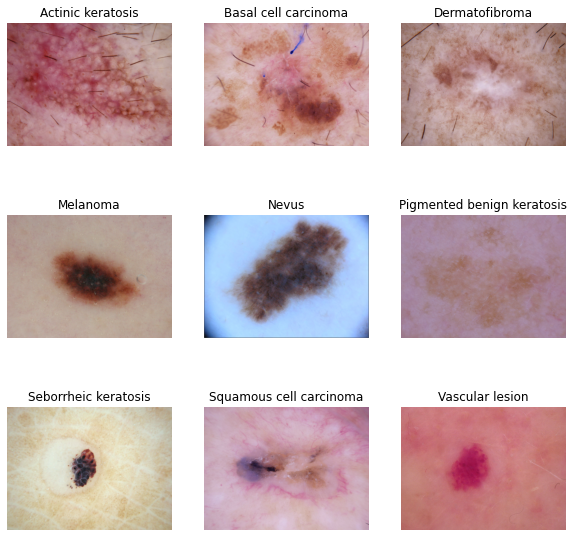

In [9]:
import matplotlib.pyplot as plt

# plotting samples from all the classes
# dir = "/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train/"

plt.figure(figsize=(10,10))

for i in range(len(class_names)):
  path = dir+class_names[i]
  files = glob.glob(path+'/*.*')
  #display(Image(files[0]))
  ax = plt.subplot(3, 3, i+1)
  img = mpimg.imread(files[0])
  plt.imshow(img)
  plt.title(class_names[i].capitalize())
  plt.axis("off")

plt.show()

The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [10]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Model 1
#### Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [11]:
# building the model
model = Sequential([
                    layers.experimental.preprocessing.Rescaling(scale=1./255, input_shape=(img_height,img_width,3)),
                    Conv2D(16, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dense(len(class_names), activation='softmax')
])


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [12]:
## "SparseCategoricalCrossentropy" loss function is selected as the labels are integers and not in one-hot encoding representation.
## Adam optimiser is selected as it adds the advantages of Adadelta & RMSprop. It is the best among the adaptive optimizers in most cases.
# Also,there is no need to focus on the learning rate value in adam optimiser.

model.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [13]:
# View the summary of all layers
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 45, 45, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 22, 22, 64)        0

### Train the model

In [14]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 733s 842ms/step - loss: 1.9714 - accuracy: 0.2654 - val_loss: 1.5580 - val_accuracy: 0.3972
Epoch 2/20
169/169 [==============================] - 3s 20ms/step - loss: 1.4646 - accuracy: 0.4542 - val_loss: 1.3936 - val_accuracy: 0.4684
Epoch 3/20
169/169 [==============================] - 3s 20ms/step - loss: 1.2698 - accuracy: 0.5267 - val_loss: 1.2115 - val_accuracy: 0.5501
Epoch 4/20
169/169 [==============================] - 3s 20ms/step - loss: 1.1115 - accuracy: 0.5907 - val_loss: 1.2066 - val_accuracy: 0.5486
Epoch 5/20
169/169 [==============================] - 3s 20ms/step - loss: 0.9913 - accuracy: 0.6319 - val_loss: 1.1365 - val_accuracy: 0.5746
Epoch 6/20
169/169 [==============================] - 3s 20ms/step - loss: 0.7941 - accuracy: 0.7157 - val_loss: 1.0323 - val_accuracy: 0.6451
Epoch 7/20
169/169 [==============================] - 3s 20ms/step - loss: 0.6748 - accuracy: 0.7585 - val_loss: 0.8646 - val_accuracy: 0.7

### Visualizing training results

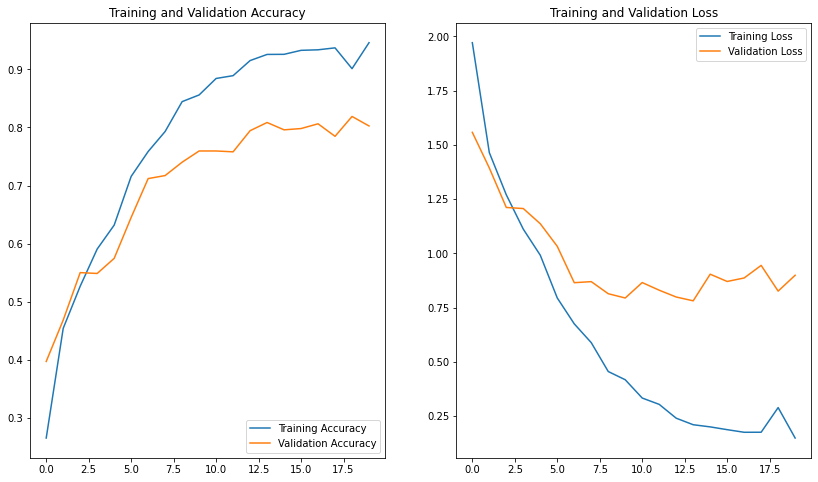

In [15]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### After fitting the model, we can see training accuracy kept on increasing and reached 90% but, after 5 epochs validation accuracy stopped improving and settled around 50%. Also, its evident that the training loss reduced significantly but, validation loss worsened. This is a clear sign of overfitting.

### Model 2

In [16]:
# data augumentation strategy as the model is overfitting
data_augmentation = Sequential([
                        layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
                        layers.experimental.preprocessing.RandomRotation(0.15),
                      ])

Rescaling = Sequential([
                        layers.experimental.preprocessing.Rescaling(scale=1./255),
                       ])

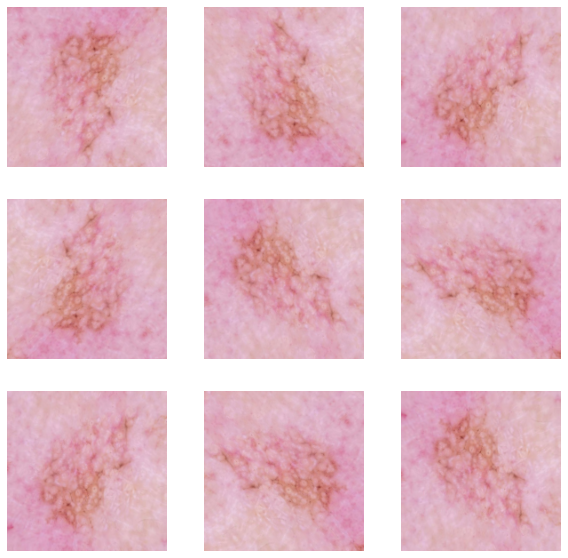

In [17]:
## Demonstrating data augmentation strategy on a single image

# Extracting the image
image, label = next(iter(train_ds))

# Adding the image to batch for data augmentation
image = tf.expand_dims(image[0], 0)
image = Rescaling(image)

# Code to see the image
#img = image[0].numpy().astype('uint8')
#plt.imshow(img)

plt.figure(figsize=(10,10))
for i in range(9):
  ax = plt.subplot(3,3, i+1)
  aug_img = data_augmentation(image)
  plt.imshow(aug_img[0])
  plt.axis('off')
  
plt.show()

### Create the model, compile and train the model


In [18]:
## You can use Dropout layer if there is an evidence of overfitting in your findings
## Model building
model2 = Sequential([
                    data_augmentation,
                    Rescaling,
                    Conv2D(16, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.20),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.20),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.20),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(0.50),
                    Dense(len(class_names), activation='softmax')
])

### Compiling the model

In [19]:
# Compiling the model
model2.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

### Training the model

In [20]:
# Fitting the model
epochs = 20
history2 = model2.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
169/169 [==============================] - 5s 25ms/step - loss: 2.1751 - accuracy: 0.1771 - val_loss: 1.9374 - val_accuracy: 0.2955
Epoch 2/20
169/169 [==============================] - 4s 24ms/step - loss: 1.8166 - accuracy: 0.2927 - val_loss: 1.6061 - val_accuracy: 0.4195
Epoch 3/20
169/169 [==============================] - 4s 24ms/step - loss: 1.6211 - accuracy: 0.3700 - val_loss: 1.5408 - val_accuracy: 0.4306
Epoch 4/20
169/169 [==============================] - 4s 24ms/step - loss: 1.5735 - accuracy: 0.3969 - val_loss: 1.4537 - val_accuracy: 0.4506
Epoch 5/20
169/169 [==============================] - 4s 24ms/step - loss: 1.5425 - accuracy: 0.4136 - val_loss: 1.4037 - val_accuracy: 0.4447
Epoch 6/20
169/169 [==============================] - 4s 24ms/step - loss: 1.5181 - accuracy: 0.4190 - val_loss: 1.4020 - val_accuracy: 0.4892
Epoch 7/20
169/169 [==============================] - 4s 24ms/step - loss: 1.4738 - accuracy: 0.4284 - val_loss: 1.4483 - val_accuracy: 0.4157

In [21]:
# Model summary
model2.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_1 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout (Dropout)            (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 45, 45, 32)       

### Visualizing the results

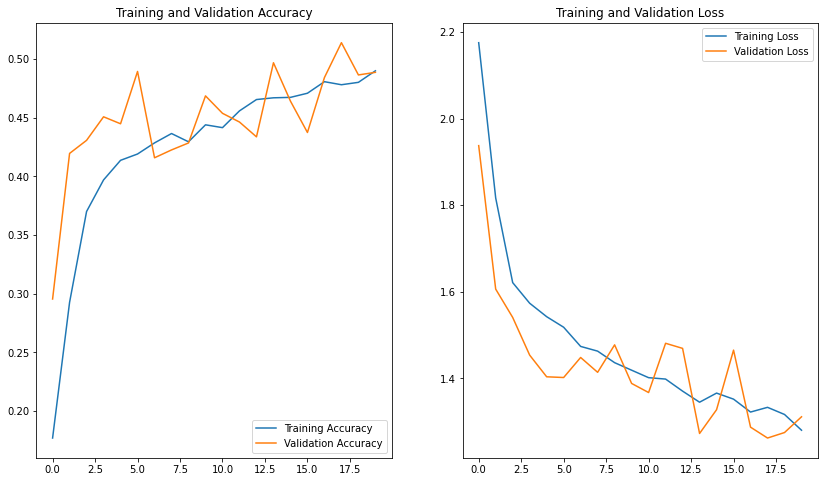

In [22]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']

loss = history2.history['loss']
val_loss = history2.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### This model is now not overfitting after we used data augmentation technique and added dropout layers. But, its evident that the training accuracy reduced significantly and now, its relative to validation accuracy. The same can be said for the loss too. Both training and validation losses reduced and are comparable to each other. But , the accuracy is almost 50% which shows that the model is now underfitting.

### Model 3
#### Find the distribution of classes in the training dataset.
#### Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [ ]:
# finding the number of files in each class

for subdir, dirs, files in os.walk(dir):
  if os.path.basename(subdir):
     print (f'Class : {os.path.basename(subdir).capitalize()} has Images : {len(files)}')  

In [24]:
# Creating the dataframe

path_list = [x for x in data_dir_train.glob('*/*.jpg')]

dir_list = [os.path.basename(os.path.dirname(x)) for x in data_dir_train.glob('*/*.jpg')]

dataframe_dict = dict(zip(path_list, dir_list))

original_df = pd.DataFrame(list(dataframe_dict.items()), columns= ['Path', 'Label'])

# Other way to create df
# original_df = pd.concat([pd.DataFrame(path_list, columns=['Path']), pd.DataFrame(dir_list, columns=['Label'])])

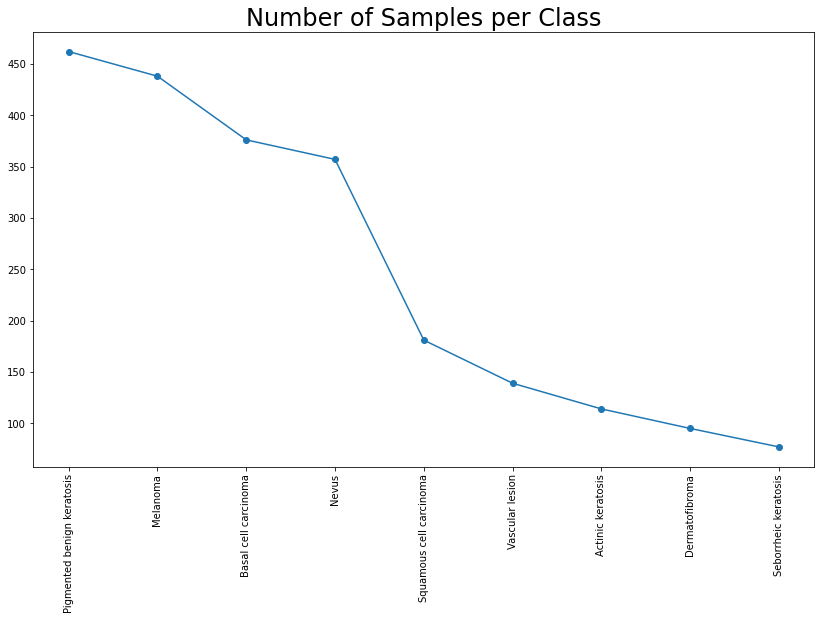

In [25]:
# plotting number of images

values_df = pd.DataFrame(original_df['Label'].value_counts()).reset_index()
values_df['index'] = values_df['index'].str.capitalize()

plt.figure(figsize=(14,8))
plt.plot(values_df['index'], values_df['Label'])
plt.scatter(values_df['index'], values_df['Label'])
plt.xticks(rotation=90)
plt.title('Number of Samples per Class', fontsize=24)
plt.show()

#### Write your findings here: 
#### - Which class has the least number of samples?
      Class 'Seborrheic keratosis' has the least number of samples (77)
#### - Which classes dominate the data in terms proportionate number of samples?
      Class 'Pigmented benign keratosis' has the highest number of samples and dominate the data with samples (462)


#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

In [ ]:
!pip install Augmentor

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


In [ ]:
path_to_training_dataset=dir
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

In [26]:
image_count_train = len(list(data_dir_train.glob('*/output/*.jpg')))
print(image_count_train)

4500


### Lets see the distribution of augmented data after adding new images to the original training data.

In [ ]:
path_list_new = [x for x in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
path_list_new

In [ ]:
lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob.glob(os.path.join(data_dir_train, '*','output', '*.jpg'))]
lesion_list_new

In [29]:
dataframe_dict_new = dict(zip(path_list_new, lesion_list_new))

In [30]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
df2['Label'].value_counts()

basal cell carcinoma          500
pigmented benign keratosis    500
squamous cell carcinoma       500
dermatofibroma                500
melanoma                      500
vascular lesion               500
seborrheic keratosis          500
actinic keratosis             500
nevus                         500
Name: Label, dtype: int64

In [31]:
new_df = original_df.append(df2)
new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### Train the model on the data created using Augmentor

In [32]:
batch_size = 32
img_height = 180
img_width = 180

#### Create a training dataset

In [33]:
# Loading data with the augmentor generated files
data_dir_train= pathlib.Path("/content/gdrive/MyDrive/Skin cancer ISIC The International Skin Imaging Collaboration/Train")
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


#### Create a validation dataset

In [34]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_dir_train,
  seed=123,
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


#### Create your model (make sure to include normalization)

In [35]:
## Model building
model3 = Sequential([
                    Rescaling,
                    Conv2D(16, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.20),
                    Conv2D(32, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.20),
                    Conv2D(64, 3, padding='same', activation='relu'),
                    MaxPooling2D(),
                    Dropout(0.20),
                    Flatten(),
                    Dense(128, activation='relu'),
                    Dropout(0.50),
                    Dense(len(class_names), activation='softmax')
])

#### Compile your model (Choose optimizer and loss function appropriately)

In [36]:
# Compiling the model
model3.compile(optimizer='adam',
              loss=SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

#### Train your model

In [37]:
epochs = 30 # using 30 epochs as mentioned in the problem statement

history3 = model3.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 31s 176ms/step - loss: 2.1499 - accuracy: 0.2014 - val_loss: 1.9110 - val_accuracy: 0.2687
Epoch 2/30
169/169 [==============================] - 30s 175ms/step - loss: 1.6463 - accuracy: 0.3694 - val_loss: 1.5290 - val_accuracy: 0.4120
Epoch 3/30
169/169 [==============================] - 30s 175ms/step - loss: 1.5282 - accuracy: 0.4173 - val_loss: 1.4215 - val_accuracy: 0.4209
Epoch 4/30
169/169 [==============================] - 30s 173ms/step - loss: 1.4306 - accuracy: 0.4434 - val_loss: 1.3916 - val_accuracy: 0.4425
Epoch 5/30
169/169 [==============================] - 30s 175ms/step - loss: 1.3296 - accuracy: 0.4881 - val_loss: 1.2774 - val_accuracy: 0.5078
Epoch 6/30
169/169 [==============================] - 30s 174ms/step - loss: 1.2701 - accuracy: 0.5095 - val_loss: 1.2418 - val_accuracy: 0.5137
Epoch 7/30
169/169 [==============================] - 30s 173ms/step - loss: 1.2017 - accuracy: 0.5464 - val_loss: 1.1542 - val_ac

#### Visualize the model results

In [38]:
model3.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
sequential_2 (Sequential)    (None, 180, 180, 3)       0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 180, 180, 16)      448       
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 90, 90, 16)        0         
_________________________________________________________________
dropout_4 (Dropout)          (None, 90, 90, 16)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 90, 90, 32)        4640      
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 45, 45, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 45, 45, 32)       

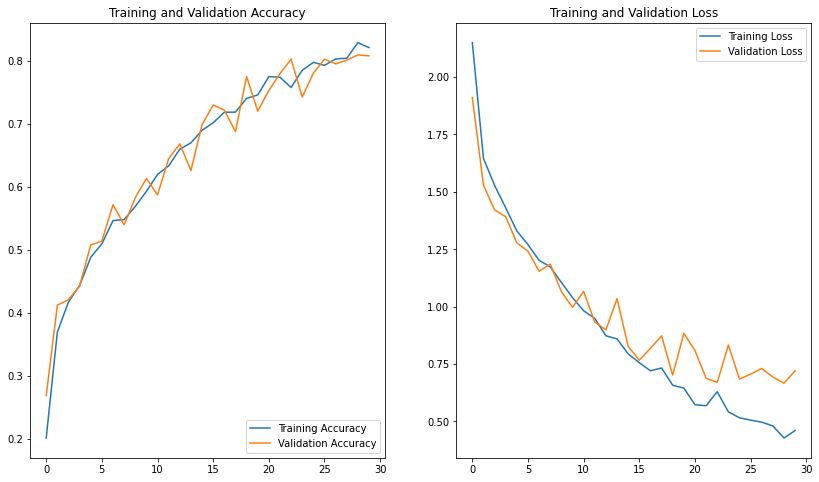

In [40]:
acc = history3.history['accuracy']
val_acc = history3.history['val_accuracy']

loss = history3.history['loss']
val_loss = history3.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(14, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

After using Augmentor library, we generated 500 samples per class which helped in balancing the dataset. Its observed that after running 30 epochs on this model, Training and Validation accuracy improved considerable to 79%. Training and Validation loss also reduced significantly. We got rid of overfitting/underfitting by balancing our data samples and achieved good results in terms of accuracy without changing the model structure/layers and filters.

